Individual Project Planning

In this project, our group will conduct a complete data science workflow to explore and predict player behavior on a video game research server. The dataset comes from a real-world study conducted by a research group in Computer Science at UBC, led by Frank Wood, which investigates how people play and interact within a Minecraft environment. 

In this planning report, I will conduct a preliminary organization, analysis, and visualization of the data, including a discussion of future methods in the end.

1.Broad Question

The broad question I intend to address is "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?" My specific question is "Is played_hours a good predictor of the subscription status of a game-related newsletter? Is it tend to be longer among younger people?"

2.Data Description, Wrangling, and Analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(lubridate)
library(patchwork)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

We have two datasets: players and sessions. 

In [2]:
player <- read_csv("data/players.csv")
head(player, 5)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21


The players dataset contains 7 variables in total. Each variable contains 196 observations.

| variable      | type         | description                                       |
| ------------- | ------------ | ------------------------------------------------- |
| experience    | character    | Gaming experience                                 |
| subscribe     | logical      | Whether the player subscribes to the newsletter   |
| hashedEmail   | character    | Anonymized email identifier                       |
| played_hours  | numeric      | Hours the player has played                       |
| name          | character    | Player name                                       |
| gender        | character    | Player gender                                     |
| Age           | numeric      | Player age                                        |

Since this dataset is already tidy, now we can calculate the summary statistics of played_hours and Age. The Age column contains one NA values, so I first remove the NA values and name this new dataset "players". 

In [3]:
players <- player |>
   filter(!is.na(played_hours), !is.na(Age))

played_hours_stat <- players |>
   summarise(mean = mean(played_hours),
    median = median(played_hours),
    sd = sd(played_hours),
    min = min(played_hours),
    max = max(played_hours)) |>
    round(2)
Age_stat <- players |>
   summarise(mean = mean(Age),
    median = median(Age),
    sd = sd(Age),
    min = min(Age),
    max = max(Age)) |>
    round(2)

played_hours_stat
Age_stat

mean,median,sd,min,max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.9,0.1,28.5,0,223.1


mean,median,sd,min,max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21.14,19,7.39,9,58


In [4]:
players_stat <- tibble(mean_played_hours = 5.9, mean_Age = 21.14)
players_stat

mean_played_hours,mean_Age
<dbl>,<dbl>
5.9,21.14


Now we explore the "sessions" dataset.

In [5]:
session <- read_csv("data/sessions.csv")
head(session, 5)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12


The sessions dataset contains 5 variables in total. Each variable contains 1535 observations.

| variable             | type         | description                                       |
| -------------------- | ------------ | ------------------------------------------------- |
| hashedEmail          | character    | Anonymized email identifier                       |
| start_time           | character    | Session start time                                |
| end_time             | character    | Session end time                                  |
| original_start_time  | numeric      | Session start time encoded by computers           |
| original_end_time    | numeric      | Session end time encoded by computers             |

The dataset is not tidy since the start_time and end_time contain more than one value in a cell (date and time). We can create a new double variable called session_time using end_time minus start_time. However, there is one potential problem: the start_time and end_time are currently character strings. If we want to do time calculations, we need to convert them into date-time first. The original_start_time and original_end_time are not human readable, and we already have readable start_time and end_time, so they will be removed. 

In [6]:
sessions <- session |> 
    mutate(start_time = dmy_hm(start_time), end_time = dmy_hm(end_time)) |>
    mutate(session_time_min = as.numeric(difftime(end_time, start_time, units = "mins")),
           session_time_min = pmax(session_time_min, 0)) |> 
    select(hashedEmail, session_time_min) |>
    filter(!is.na(session_time_min), !is.na(hashedEmail)) 
head(sessions, 5)

hashedEmail,session_time_min
<chr>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,13
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,23
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,36
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,11


Below provides the summary statistics of the session_time variable.

In [7]:
session_time_stat <- sessions |>
   summarise(mean = mean(session_time_min),
    median = median(session_time_min),
    sd = sd(session_time_min),
    min = min(session_time_min),
    max = max(session_time_min)) |>
    round(2)
session_time_stat

mean,median,sd,min,max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
50.86,30,55.57,3,259


3. Visualization

We will be mainly using observations in the subscribe, played_time, and Age columns. The following are some exploratory visualizations of these three variables.

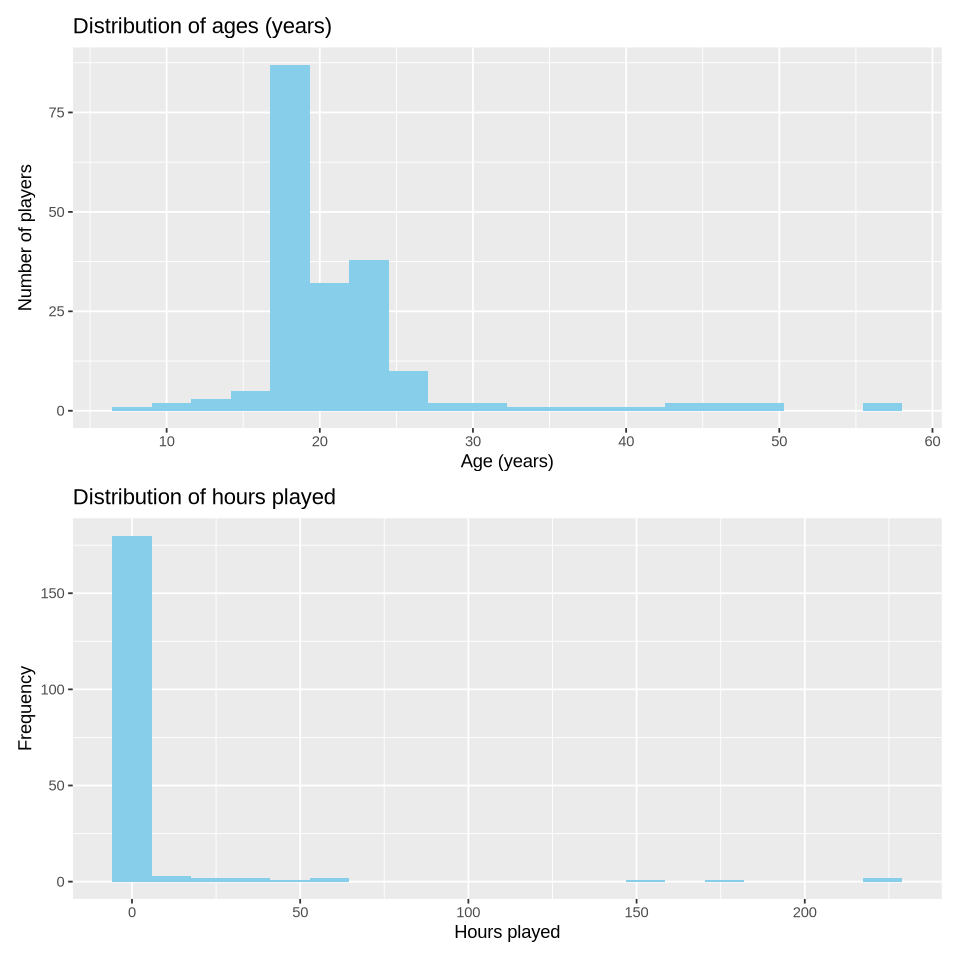

In [8]:
options(repr.plot.width = 8, repr.plot.height = 8)
Age_plot <- ggplot(data = players, aes(x = Age)) +
  geom_histogram(bins = 20, fill = "skyblue") +
  labs(title = "Distribution of ages (years)", 
       x = "Age (years)", y = "Number of players")

hours_plot <- ggplot(data = players, aes(x = played_hours)) +
  geom_histogram(bins = 20, fill = "skyblue") +
  labs(title = "Distribution of hours played", 
       x = "Hours played", y = "Frequency")

Age_plot / hours_plot

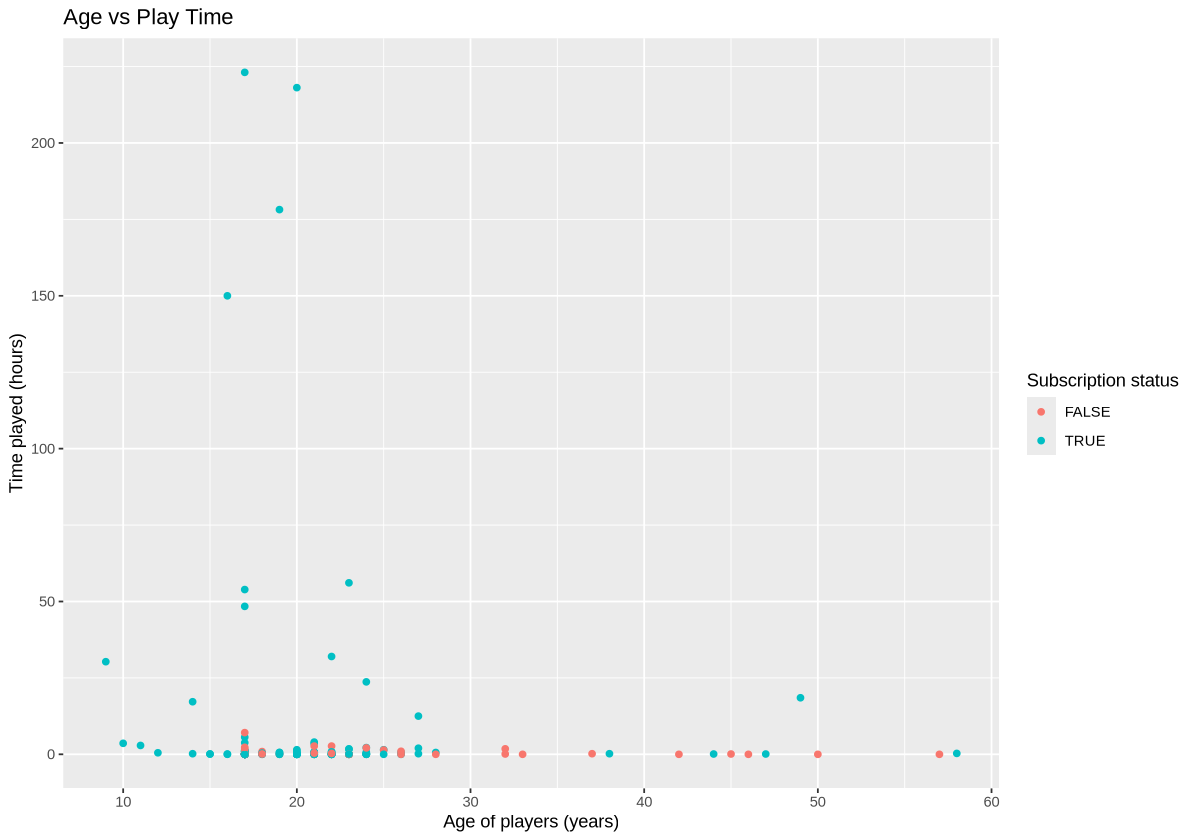

In [9]:
options(repr.plot.width = 10, repr.plot.height = 7)
subscribe_plot <- ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
   geom_point() + 
   labs(x = "Age of players (years)", y = "Time played (hours)", color = "Subscription status", title = "Age vs Play Time")
subscribe_plot

From the first two graphs we know that most players play under 10 hours and the majority of players are between 15 and 30 years old. Both variables have significant outliers (old players and long gaming times). The scatterplot shows that older players' gaming times tend to be relatively low. A few subscribed players, particularly under age 25, play dramatically more hours (above 100), indicating highly engaged users. Both subscribed and non-subscribed players appear across all age groups. However, the high-hour outliers mostly belong to the subscribed group, suggesting that subscription may be associated with greater playtime. In general, this visualization supports that played_hours is positively associated with subscription, particularly among younger players, and gives initial, descriptive evidence for my question.

I scale the variables and make the scatterplot again and find that the pattern is the same with scaled variables.

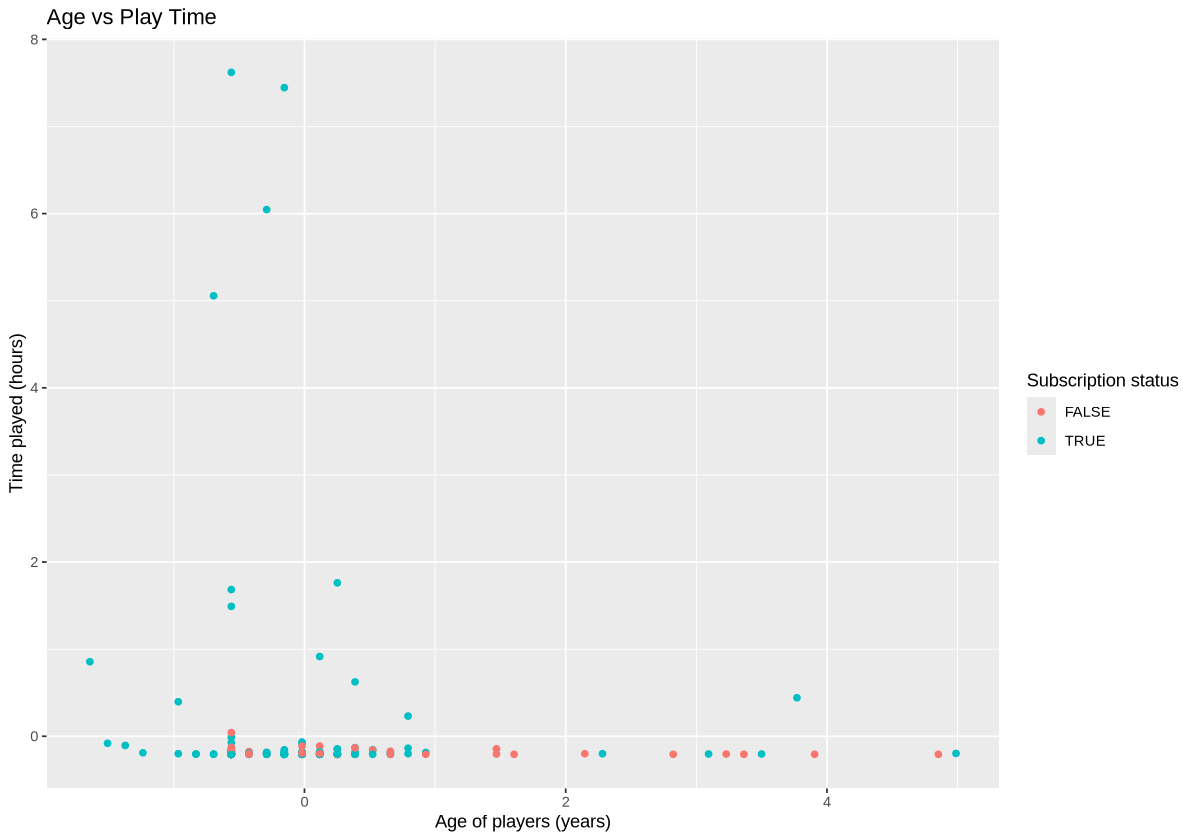

In [10]:
players_scaled <- players|>
   mutate(Age = scale(Age), played_hours = scale(played_hours)) 

options(repr.plot.width = 10, repr.plot.height = 7)
subscribe_plot_scaled <- ggplot(players_scaled, aes(x = Age, y = played_hours, color = subscribe)) +
   geom_point() + 
   labs(x = "Age of players (years)", y = "Time played (hours)", color = "Subscription status", title = "Age vs Play Time")
subscribe_plot_scaled

4. Methods and Plan

To examine whether played_hours can predict newsletter subscription, I plan to use a kknn classification model. This method is appropriate because the outcome variable, subscribe, is binary, and kknn is a flexible classifier that does not assume linear relationships or specific distributions. It classifies users based on the behaviour of nearby players, which fits well with the idea that players with similar gameplay patterns may have similar subscription tendencies. Before modelling, I will clean the data, remove NA values, and standardize numeric predictors. I will split the data into 70% training and 30% testing, and then use 5-fold cross-validation on the training set to choose the best value of k. Model performance will be assessed using accuracy and confusion matrices, and the final selected model will be evaluated on the test set. Potential limitations include the sensitivity of kknn model to outliers, class imbalance, and the choice of k. 

To further address whether younger players tend to have longer played_hours, I will use ggplot visualizations rather than a predictive model. This question is descriptive in nature, and visualization is well-suited for exploring trends in game time across ages. I will create plots such as boxplots comparing played_hours across age groups or histograms showing the general trend of played_hours across age. These visualizations will help reveal general patterns, though they cannot establish causation and may be affected by skewed data or uneven group sizes. By combining kknn classification for the predictive question and ggplot visual exploration for age-related patterns, this plan provides a structured and appropriate approach to addressing both parts of the question. 